## Introduction

This notebook covers:

1. Inspecting KMeans Clustering's result with K=2
2. Hyperarameter Tuning
    - Selecting Inerita with Elbow Method
    - Selecting best K with Silhoutte Method
    - Distance metrics
3. Feature Engineering with KMeans in ML Classification

In [100]:
from __future__ import print_function
import os
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.linear_model import LogisticRegression

data_path = ['data']

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


## Read preprocessing data from the EDA Notebook

In [101]:
pkl_path = os.sep.join(data_path + ['win_quality_preprocessing.pkl'])

pkl_file = open(pkl_path, 'rb')

data =  pickle.load(pkl_file)

data.head().T


,0,1,2,3,4
fixed_acidity,0.142473,0.451036,0.451036,3.07382,0.142473
volatile_acidity,2.18883,3.28223,2.5533,-0.362438,2.18883
citric_acid,-2.19283,-2.19283,-1.91755,1.66109,-2.19283
residual_sugar,-0.744778,-0.59764,-0.660699,-0.744778,-0.744778
chlorides,0.569958,1.19797,1.0267,0.541412,0.569958
free_sulfur_dioxide,-1.10014,-0.31132,-0.874763,-0.762074,-1.10014
total_sulfur_dioxide,-1.44636,-0.862469,-1.09249,-0.986324,-1.44636
density,1.03499,0.701486,0.768188,1.10169,1.03499
pH,1.81309,-0.115073,0.25812,-0.363868,1.81309
sulphates,0.193097,0.999579,0.797958,0.32751,0.193097


## KMeans Clustering

- Fit a K-means clustering model with two clusters.


- Examine the clusters by wine color.

In [102]:

float_columns = [x for x in data.columns if x not in ['color', 'quality']]

km = KMeans(n_clusters=2, random_state=42)

data['kmeans'] = km.fit_predict(data[float_columns])

data.loc[:4].T

,0,1,2,3,4
fixed_acidity,0.142473,0.451036,0.451036,3.07382,0.142473
volatile_acidity,2.18883,3.28223,2.5533,-0.362438,2.18883
citric_acid,-2.19283,-2.19283,-1.91755,1.66109,-2.19283
residual_sugar,-0.744778,-0.59764,-0.660699,-0.744778,-0.744778
chlorides,0.569958,1.19797,1.0267,0.541412,0.569958
free_sulfur_dioxide,-1.10014,-0.31132,-0.874763,-0.762074,-1.10014
total_sulfur_dioxide,-1.44636,-0.862469,-1.09249,-0.986324,-1.44636
density,1.03499,0.701486,0.768188,1.10169,1.03499
pH,1.81309,-0.115073,0.25812,-0.363868,1.81309
sulphates,0.193097,0.999579,0.797958,0.32751,0.193097


In [103]:
(data[['color','kmeans']]
 .groupby(['color','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color kmeans        
red   0           24
      1         1575
white 0         4831
      1           67

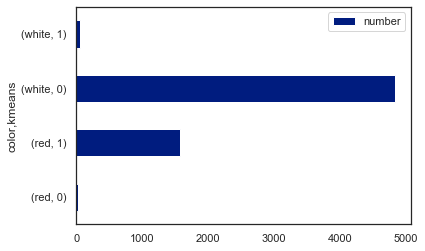

In [104]:
(data[['color', 'kmeans']]
.groupby(['color', 'kmeans'])
.size()
.to_frame()
.rename(columns={0: 'number'}).plot(kind='barh'))

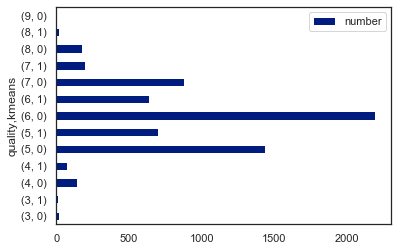

In [105]:
(data[['quality', 'kmeans']]
.groupby(['quality', 'kmeans'])
.size()
.to_frame()
.rename(columns={0: 'number'}).plot(kind='barh'))

**Observation**

- By choosing k=2, we can see that white wine is mainly distributed in cluster 1 meanwhile, datapoints of red wine is mostly distributed in cluster 2

- The number of datapoints in cluster 2 are just a half of cluster 1. 

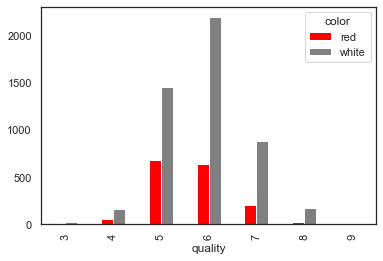

In [106]:
pd.crosstab(data['quality'], data['color']).plot(kind='bar', color=['red', 'gray'])

### Hyperparameter Tuning

We have to select the best number of clusters with the help of inertia, silhouette score and distance metrics

#### 1. Selecting Inerita with Elbow Method

- Pick range of candidate values of K (e.g. 1 to 20)
- Calculate average distance from centroid for each value
- Plot and find elbow


- Now fit K-Means models with cluster values ranging from 1 to 20.
- For each model, store the number of clusters and the inertia value.
- Plot cluster number vs inertia. Does there appear to be an ideal cluster number?

In [107]:
# Create and fit a range of models
km_list = list()
ns = range(1,20)
kmean_state = 42

for clust in ns:
    
    km = KMeans(n_clusters=clust, random_state = kmean_state)
    
    km = km.fit(data[float_columns])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

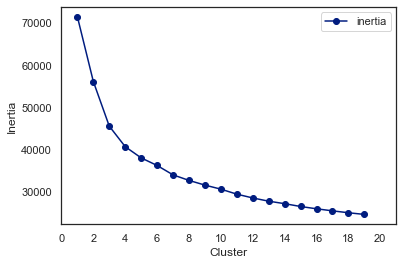

In [108]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))

ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

**Observation**: 
- When we changed the cluster value from 1 to 2, the inertia value reduced very sharply. This decrease in the inertia value reduces and eventually becomes constant as we increase the number of clusters further.


- Here, we can choose any number of clusters between 4 and 8. You must also look at the computation cost while deciding the number of clusters. If we increase the number of clusters, the computation cost will also increase. So, if you do not have high computational resources, my advice is to choose a lesser number of clusters.

#### 2. Selecting best K with Silhoutte Method

- Pick range of candidate values of K (e.g.1 to 10)
- Plot silhouettes for each value of K Ideal value of silhouette = 1
- The score runs -1 to 1. The worst value is -1 and the best value is 1. Value near 0 means clusters are overlapping. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar



**Selecting the number of clusters in range of 2 and 8 with silhouette analysis <code>sklearn.metrics.silhouette_score</code> on KMeans clustering**

- How does sihouette_score help to select the best cluster number in KMeans? It computes the mean between datapoints to centroid in the sample cluster Silhouette Coefficient of all samples


- How can we intepret sihouette score? The score runs -1 to 1. The worst value is -1 and the best value is 1. Value near 0 means clusters are overlapping. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar

In [109]:
def silhoutte_4_kmean(n_clusters, data):
    
    silhouettes = {}
    selected_ns = range(2, n_clusters)
    
    for clust in selected_ns:

        clusterer = KMeans(n_clusters = clust
                           , random_state = kmean_state
                           , init='k-means++')

        cluster_labels = clusterer.fit_predict(data)

        silhouette_avg = silhouette_score(data, cluster_labels)

        silhouettes.update({clust: silhouette_avg})     

    return sorted(silhouettes.items(), key = lambda item : item[1])

In [110]:
silhoutte_4_kmean(8, data[float_columns])

[(6, 0.17441943513502067),
 (7, 0.1802088065495668),
 (5, 0.18032635697467655),
 (3, 0.23507051305670537),
 (4, 0.24752476415517888),
 (2, 0.2765206322693147)]

**Observation**

- The best cluster that provides the highest sihouette score is 2.

- In above KMeans, Euclidean distance is used by default to calculate the Sihouette Coefficient in KMeans if we don't specify a distance metric.

- We will experiment KMeans with some other distance metrics such as Manhattan, Cosine and Jaccard.

- **How do distance metrics impact on the Clustering?**

#### 3. Distance metrics 

- Choice of distance metric is extremely important to clustering success
- Each metric has strengths and most appropriate use-cases but sometimes choice of distance metric is also based on empirical evaluation


**1. Euclidean distance**
- The Euclidean distance is the square root of sums of squares of pairs of values from rows or columns.
- Data normalization and missing values processing must be taken into account before using this metric




**2. Cosine distance**

- Cosine similarity is the dot product divided by the product of lengths (where the length is the square of dot product of a row/column with itself). Cosine distance is computed by subtracting the similarity from 1.

- In calculation of dot products, missing values are replaced by means. In calculation of lengths, the contribution of a missing value equals the square of the mean plus the variance.

**Euclidean vs Cosine Distance**

- Euclidean is useful for coordinate based measurements
- Cosine is better for data such as text where location of occurrence is less important
- Euclidean distance is more sensitive to curse of dimensionality


**3. Jaccard distance**
- Jaccard similarity between two sets X and Y is defined as the size of their intersection (X ∩ Y) divided by the size of the union (X ∪ Y). Jaccard distance is computed by subtracting the similarity from 1.

- Applies to sets (like word occurrence):

    ▪ Sentence A: “I like chocolate ice cream.”
    
    ▪ set A = {I, like, chocolate, ice, cream}
    
    ▪ Sentence B: “Do I want chocolate cream or vanilla cream?”
    
    ▪ set B = {Do, I, want, chocolate, cream, or, vanilla}
    
    ▪ Jaccard distance(sentence A, sentence B) = 1 - ( 𝐴 ∩ B)/ (𝐴 ∪ 𝐵) = 1 - 3/9 

 

**4. Manhattan distance**
- It is the sum of absolute pairwise distances.

    
- Normalization and treatment of missing values is similar as in the Euclidean distance, except that medians and median absolute distance from the median (MAD) are used instead of means and deviations.
    
    
- For discrete values, distances are again 0 or 1, hence the Manhattan distance for discrete columns is the same as the Euclidean.



In [111]:
def silhouette_4_kmean_with_metrics(n_clusters
                       , distance_metrics
                       , data):
    '''
    @n_cluster: int: the number of clusters are use in K_mean
    @distance_metrics : list : a list of specified distance metric
    @data: 1D array : A sample data
    '''
    total_score = {}
    
    ns = range(2, n_clusters + 1 )
    
    for metric in distance_metrics:
        
        silhouettes = {}

        for clust in ns:

            clusterer = KMeans(n_clusters = clust, init='k-means++', random_state = kmean_state)
            
            cluster_labels = clusterer.fit_predict(data)

            silhouette_avg = silhouette_score(data, cluster_labels,  metric = metric)
            #keep the average score in the dictionry
            silhouettes.update({clust : silhouette_avg}) 

            # sort the dictionary
        s_silhouettes = sorted(silhouettes.items(), key = lambda item : item[1], reverse=True)
        total_score.update({metric : s_silhouettes[0]})
        
    return total_score

In [112]:
silhouette_4_kmean_with_metrics(8
                        , ["euclidean", "jaccard", "manhattan", "cosine"]
                        , data[float_columns])

{'euclidean': (2, 0.2765206322693147),
 'jaccard': (2, 0.0),
 'manhattan': (2, 0.3055458866243606),
 'cosine': (3, 0.39314364693531917)}

**Observation**:

- The sihoutte score is highest with KMeans=3 and distance metric = cosine distance
- The optimal cluster number is selected differently among metrics

### Feature Engineering with Clustering in Classification

In this section, we are going to explore clustering as a form of feature engineering.

- Create a binary target variable y, denoting if the quality is greater than 6 or not.
- Create a variable called X_with_kmeans from data, by dropping the columns "quality", "color"  from the dataset.
- Create X_without_kmeans from that by dropping "kmeans".
- For both datasets, using StratifiedShuffleSplit with 10 splits, fit 10 Random Forest Classifiers and average out the roc-auc scores.
- Compare the average roc-auc scores for the models using the kmeans clusters as a feature and the one that doesn't use it.

In [113]:
# 1) binary target varibale y
# y=0 denotes wine quality between 3 and 6
# y=1 denotes wine quality between 7 and 9
y = (data['quality'] > 6).astype(int)
y.value_counts()

0    5220
1    1277
Name: quality, dtype: int64

In [114]:
# 2) Create X_with_kmeans
# Initialize KMeans with K=3
km = KMeans(n_clusters = 3, random_state = kmean_state)
X_without_kmeans = data[float_columns]
# Add kmeans column to X_with_kmeans 
X_with_kmeans = data[float_columns]
X_with_kmeans['kmeans'] = km.fit_predict(data[float_columns])
X_with_kmeans.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,kmeans
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,0
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,0
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0


In [115]:
# 4) Split dataset into trainset and testset with StratifiedShuffleSplit
# 4) Fit them to RandomeForestClassifier
# 4) Compute ROCAUC score
def get_avg_roc_10splits(estimator, X, y):
    
    sss = StratifiedShuffleSplit(n_splits = 10, random_state = kmean_state)
    roc_auc_list = []
    
    for train_index, test_index in sss.split(X, y):     
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        y_scored = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
        
    return np.mean(roc_auc_list)


estimator = LogisticRegression()

roc_with_kmeans = get_avg_roc_10splits(estimator, X_with_kmeans, y)

roc_without_kmeans = get_avg_roc_10splits(estimator, X_without_kmeans, y)

print("Without kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_without_kmeans))
print("Using kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_with_kmeans))

Without kmeans cluster as input to Random Forest, roc-auc is "0.8165244851532567"
Using kmeans cluster as input to Random Forest, roc-auc is "0.8178505148467432"


**Let's now explore if the number of clusters have an effect in this improvement.**

* Create the basis training set from `data` by restricting to float_columns.
* For $n = 1, \ldots, 20$, fit a kmeans algotihm with n clusters. One hot encode it and add it to the **basis** training set. Don't add it to the previous iteration.
* Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
* Plot the average roc-auc scores.

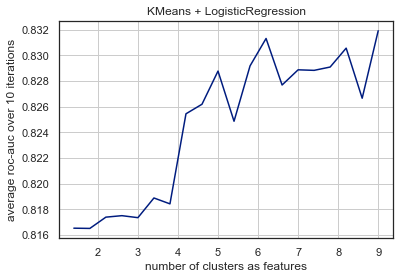

In [116]:
from sklearn.linear_model import LogisticRegression

X_basis = data[float_columns]

def create_kmeans_columns(data, n):
    
    km = KMeans(n_clusters=n, random_state = kmean_state)
    km_col = pd.Series(km.fit_predict(data))
    km_cols = pd.get_dummies(km_col, prefix='kmeans_cluster')
    return pd.concat([data, km_cols], axis=1)


estimator = LogisticRegression()
ns = range(1, 21)
roc_auc_list = [get_avg_roc_10splits(estimator, create_kmeans_columns(X_basis, n), y)
                for n in ns]


# seaborn styles
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

ax = plt.axes()
ax.plot(ns, roc_auc_list)
ax.set(
    xticklabels= ns,
    xlabel='number of clusters as features',
    ylabel='average roc-auc over 10 iterations',
    title='KMeans + LogisticRegression'
)
ax.grid(True)

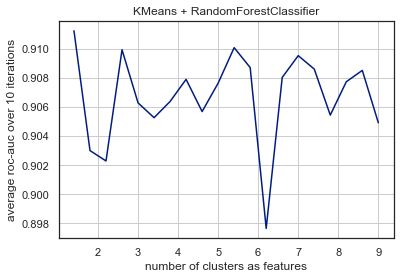

In [117]:
estimator = RandomForestClassifier()

roc_auc_list = [get_avg_roc_10splits(estimator, create_kmeans_columns(X_basis, n), y)
                for n in ns]

# seaborn styles
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

ax = plt.axes()
ax.plot(ns, roc_auc_list)
ax.set(
    xticklabels= ns,
    xlabel='number of clusters as features',
    ylabel='average roc-auc over 10 iterations',
    title='KMeans + RandomForestClassifier'
)
ax.grid(True)